# **1.Conectamos Colab con Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
PATH_ORIGEN = "/content/drive/MyDrive/Proyectos-independientes/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG"
os.chdir(PATH_ORIGEN)

In [67]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 9.9 MB/s 


In [76]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py
import utils
import pandas as pd 
import tensorflow_addons as tfa

In [4]:
sys.path.append(os.path.abspath(PATH_ORIGEN))

# **2.Train / Test**

In [5]:
# Nota: La ventana de vectores que entra a la LSTM son en total 81 vectores de 46 elementos
size_ventana = 81 
num_resonancias = 369
num_registros = size_ventana * num_resonancias 
print(num_registros)

29889


In [6]:
# Leemos el dataset de pandas
df = pd.read_csv("./features-gabor/features_total.csv")
df = df.iloc[0:num_registros,:]
print(df.shape)

(29889, 47)


In [7]:
df.head(10)

,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,20553340.0,26512668.0,19575162.0,25475152.0,39146464.0,22807534.0,40261488.0,39833956.0,40725752.0,41403548.0,21826196.0,26134852.0,20076274.0,25058532.0,38804220.0,24019034.0,39920024.0,38810364.0,40424232.0,40744664.0,21746586.0,25955292.0,20477240.0,24754088.0,38391704.0,24745500.0,39376472.0,38109236.0,40029528.0,39650504.0,21661632.0,26118642.0,19852464.0,25176348.0,38648880.0,23586508.0,39629792.0,39022076.0,40183996.0,40525600.0,0.033680,0.867319,22.134233,2.183239,0.183522,0.396612,1
1,20354448.0,26775928.0,17014256.0,25869584.0,39109708.0,20870628.0,40487728.0,40201712.0,40950048.0,41727112.0,21864332.0,26491016.0,17305140.0,25478888.0,38733384.0,21788300.0,40080976.0,39169428.0,40627864.0,41048868.0,21890608.0,26099228.0,17812116.0,25007592.0,38244776.0,22898312.0,39575688.0,38458872.0,40259204.0,39970448.0,21644396.0,26612676.0,17212644.0,25584486.0,38470768.0,21781054.0,39841908.0,39221976.0,40426608.0,40788444.0,0.033702,0.703207,39.668358,2.570703,0.183581,0.348662,1
2,19984400.0,26894900.0,15230014.0,26223200.0,38091248.0,19324408.0,40616944.0,40286752.0,41119016.0,41914740.0,21325872.0,26782828.0,15445566.0,25772004.0,37712740.0,20528740.0,40229264.0,39335592.0,40784096.0,41246064.0,21828516.0,26466488.0,15997898.0,25441804.0,37294344.0,21452796.0,39749592.0,38483592.0,40448788.0,40155536.0,21248248.0,26670450.0,15348058.0,25748398.0,37523720.0,20326448.0,39985832.0,39318512.0,40546164.0,41053960.0,0.036406,0.767346,48.062935,2.879774,0.190804,0.333588,1
3,20090340.0,27120884.0,15111876.0,26437772.0,38186168.0,19286020.0,41156576.0,40860680.0,41583824.0,42601344.0,21427550.0,27112374.0,15234752.0,26273732.0,37792180.0,20350526.0,40723984.0,39650376.0,41261548.0,41701336.0,21915176.0,26580190.0,15862270.0,25856920.0,37501544.0,21594742.0,40326176.0,38993892.0,40987744.0,40707940.0,21436556.0,27075820.0,15237754.0,26249724.0,37711028.0,20350518.0,40545960.0,39879536.0,41038096.0,41630804.0,0.037860,0.789455,46.213974,2.869358,0.194576,0.340948,1
4,20277768.0,27391262.0,14977410.0,26536104.0,37705824.0,19028904.0,41190424.0,40913780.0,41673448.0,42724016.0,21425494.0,27274290.0,14981758.0,26283232.0,37355812.0,20022896.0,40759752.0,39760580.0,41350984.0,41746356.0,22139872.0,26614660.0,15623270.0,26026968.0,37064656.0,21320984.0,40394376.0,38987512.0,41088544.0,40652920.0,21305788.0,27299868.0,14870224.0,26193422.0,37237680.0,20160548.0,40542424.0,39897592.0,41094228.0,41688668.0,0.038738,0.805872,46.820312,2.713542,0.196819,0.392367,1
5,20049852.0,27162852.0,14466772.0,26375440.0,36233016.0,18597864.0,40999344.0,40644116.0,41472432.0,42536808.0,21414528.0,27090864.0,14531069.0,26016016.0,35815224.0,19432648.0,40472968.0,39475784.0,41086248.0,41532200.0,21772200.0,26616694.0,15130040.0,25886738.0,35604348.0,20965454.0,40152532.0,38741688.0,40894764.0,40506908.0,21337438.0,26973604.0,14391620.0,26075996.0,35701864.0,19415384.0,40280880.0,39434776.0,40871464.0,41302164.0,0.038946,0.862864,39.087238,2.834635,0.197348,0.340403,1
6,20207176.0,27706724.0,14647557.0,26792082.0,36660568.0,18723104.0,41712584.0,41240144.0,42221108.0,43222640.0,21670574.0,27509910.0,14814468.0,26642992.0,36267412.0,19940176.0,41191384.0,40161680.0,41782296.0,42304240.0,22366292.0,27135170.0,15611776.0,26235564.0,36015312.0,21657568.0,40801240.0,39429688.0,41539404.0,41255712.0,21604932.0,27405684.0,14757786.0,26578720.0,36127568.0,19764866.0,40949224.0,40020296.0,41539200.0,42021344.0,0.040658,0.854682,43.250435,2.843316,0.201638,0.354572,1
7,19965272.0,27447460.0,14107531.0,26435006.0,36261848.0,18103332.0,41566312.0,40941312.0,42091604.0,42915992.0,21332340.0,27201206.0,14429026.0,26201326.0,35868936.0,19707416.0,41034440.0,39935136.0,41655808.0,42097176.0,22231344.0,268703

In [8]:
df.insert(0, 'ID', 0)
df_aux = df.copy()

In [9]:
count = 1
for i in range(0,num_registros,size_ventana):
  # Identificador
  id = 'MAT' + str(count)

  # Creamos un ID en el dataframe auxiliar 
  df_aux.iloc[i:i+size_ventana,0] = id
  
  # matriz de 81 vectores de 46 caracteristicas
  mat   = df_aux.iloc[i:i+size_ventana,:46]

  # clase a la que corresponde la resonancia
  label = np.unique(df.iloc[i:i+size_ventana,46])[0]

  count = count + 1

  #print(i)

In [10]:
df_aux.head(10)

,ID,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,MAT1,20553340.0,26512668.0,19575162.0,25475152.0,39146464.0,22807534.0,40261488.0,39833956.0,40725752.0,41403548.0,21826196.0,26134852.0,20076274.0,25058532.0,38804220.0,24019034.0,39920024.0,38810364.0,40424232.0,40744664.0,21746586.0,25955292.0,20477240.0,24754088.0,38391704.0,24745500.0,39376472.0,38109236.0,40029528.0,39650504.0,21661632.0,26118642.0,19852464.0,25176348.0,38648880.0,23586508.0,39629792.0,39022076.0,40183996.0,40525600.0,0.033680,0.867319,22.134233,2.183239,0.183522,0.396612,1
1,MAT1,20354448.0,26775928.0,17014256.0,25869584.0,39109708.0,20870628.0,40487728.0,40201712.0,40950048.0,41727112.0,21864332.0,26491016.0,17305140.0,25478888.0,38733384.0,21788300.0,40080976.0,39169428.0,40627864.0,41048868.0,21890608.0,26099228.0,17812116.0,25007592.0,38244776.0,22898312.0,39575688.0,38458872.0,40259204.0,39970448.0,21644396.0,26612676.0,17212644.0,25584486.0,38470768.0,21781054.0,39841908.0,39221976.0,40426608.0,40788444.0,0.033702,0.703207,39.668358,2.570703,0.183581,0.348662,1
2,MAT1,19984400.0,26894900.0,15230014.0,26223200.0,38091248.0,19324408.0,40616944.0,40286752.0,41119016.0,41914740.0,21325872.0,26782828.0,15445566.0,25772004.0,37712740.0,20528740.0,40229264.0,39335592.0,40784096.0,41246064.0,21828516.0,26466488.0,15997898.0,25441804.0,37294344.0,21452796.0,39749592.0,38483592.0,40448788.0,40155536.0,21248248.0,26670450.0,15348058.0,25748398.0,37523720.0,20326448.0,39985832.0,39318512.0,40546164.0,41053960.0,0.036406,0.767346,48.062935,2.879774,0.190804,0.333588,1
3,MAT1,20090340.0,27120884.0,15111876.0,26437772.0,38186168.0,19286020.0,41156576.0,40860680.0,41583824.0,42601344.0,21427550.0,27112374.0,15234752.0,26273732.0,37792180.0,20350526.0,40723984.0,39650376.0,41261548.0,41701336.0,21915176.0,26580190.0,15862270.0,25856920.0,37501544.0,21594742.0,40326176.0,38993892.0,40987744.0,40707940.0,21436556.0,27075820.0,15237754.0,26249724.0,37711028.0,20350518.0,40545960.0,39879536.0,41038096.0,41630804.0,0.037860,0.789455,46.213974,2.869358,0.194576,0.340948,1
4,MAT1,20277768.0,27391262.0,14977410.0,26536104.0,37705824.0,19028904.0,41190424.0,40913780.0,41673448.0,42724016.0,21425494.0,27274290.0,14981758.0,26283232.0,37355812.0,20022896.0,40759752.0,39760580.0,41350984.0,41746356.0,22139872.0,26614660.0,15623270.0,26026968.0,37064656.0,21320984.0,40394376.0,38987512.0,41088544.0,40652920.0,21305788.0,27299868.0,14870224.0,26193422.0,37237680.0,20160548.0,40542424.0,39897592.0,41094228.0,41688668.0,0.038738,0.805872,46.820312,2.713542,0.196819,0.392367,1
5,MAT1,20049852.0,27162852.0,14466772.0,26375440.0,36233016.0,18597864.0,40999344.0,40644116.0,41472432.0,42536808.0,21414528.0,27090864.0,14531069.0,26016016.0,35815224.0,19432648.0,40472968.0,39475784.0,41086248.0,41532200.0,21772200.0,26616694.0,15130040.0,25886738.0,35604348.0,20965454.0,40152532.0,38741688.0,40894764.0,40506908.0,21337438.0,26973604.0,14391620.0,26075996.0,35701864.0,19415384.0,40280880.0,39434776.0,40871464.0,41302164.0,0.038946,0.862864,39.087238,2.834635,0.197348,0.340403,1
6,MAT1,20207176.0,27706724.0,14647557.0,26792082.0,36660568.0,18723104.0,41712584.0,41240144.0,42221108.0,43222640.0,21670574.0,27509910.0,14814468.0,26642992.0,36267412.0,19940176.0,41191384.0,40161680.0,41782296.0,42304240.0,22366292.0,27135170.0,15611776.0,26235564.0,36015312.0,21657568.0,40801240.0,39429688.0,41539404.0,41255712.0,21604932.0,27405684.0,14757786.0,26578720.0,36127568.0,19764866.0,40949224.0,40020296.0,41539200.0,42021344.0,0.040658,0.854682,43.250435,2.843316,0.201638,0.354572,1
7,MAT1,19965272.0,27447460.0,14107531.0,26435006.0,36261848.0,18103332.0,41566312.0,40941312.0,42091604.0,42915992.0,21332340.0,27201206.0,14429026.0,26201326.0,35868936.0,19707416.0,41034440.0,3993513

## 2.1. Estratificando

In [ ]:
# Haciendo un muestreo estratificado con respecto a la clase 
# print(df['clase'].value_counts())
tipo_tumor = df['clase'].value_counts()/df['clase'].shape[0]
print(tipo_tumor)

1    0.794038
0    0.205962
Name: clase, dtype: float64


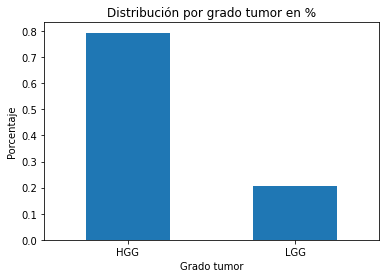

In [ ]:
# Diagrama de barras
tipo_tumor.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['HGG', 'LGG'])
plt.title("Distribución por grado tumor en %")
plt.xlabel("Grado tumor")
plt.ylabel("Porcentaje")
plt.show()

In [ ]:
df.iloc[81:81+size_ventana,:]

,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
81,19482888.0,27880508.0,21973520.0,26670852.0,38826816.0,24158732.0,40091320.0,40457304.0,40619632.0,41741100.0,21487714.0,27461724.0,22490424.0,26433684.0,38537188.0,25269404.0,39883080.0,39100048.0,40425536.0,40897328.0,21962984.0,27175890.0,23174474.0,25990514.0,38483880.0,26268180.0,39707320.0,38687760.0,40302120.0,40178248.0,21793212.0,27384476.0,22675072.0,26507090.0,38638292.0,25614778.0,39880288.0,39444592.0,40328336.0,41157616.0,0.029125,0.580609,33.739582,2.191840,0.170661,0.417403,1
82,20329920.0,28540716.0,22847152.0,27318086.0,39957376.0,25014840.0,41347388.0,41553620.0,41749296.0,43093900.0,22226156.0,28091224.0,22969858.0,27112780.0,39584592.0,25872928.0,40962164.0,40162304.0,41500736.0,42052360.0,22527836.0,27674160.0,23819464.0,26591764.0,39358748.0,27008732.0,40645040.0,39467168.0,41269476.0,40984916.0,22378238.0,28087036.0,23305500.0,26984828.0,39391204.0,26283160.0,40743272.0,40444904.0,41248912.0,42062016.0,0.030374,0.641778,32.611328,2.155078,0.174282,0.411807,1
83,20734716.0,28895468.0,22831084.0,27423330.0,40325168.0,25286986.0,41804412.0,41854104.0,42271952.0,43576528.0,22500068.0,28103792.0,23300648.0,27178016.0,39984444.0,26282372.0,41492136.0,40479768.0,42042768.0,42450580.0,22904866.0,28030616.0,23988748.0,26740000.0,39714592.0,27137812.0,41039784.0,39722768.0,41762552.0,41410784.0,22737498.0,28110692.0,23363292.0,27191998.0,39719208.0,26678992.0,41167200.0,40802840.0,41699236.0,42558832.0,0.033605,0.704615,27.882103,2.097301,0.183316,0.412272,1
84,21633604.0,29271330.0,23032444.0,27950064.0,41325040.0,25684658.0,43011632.0,42827304.0,43462904.0,44548132.0,22995548.0,28754646.0,23479052.0,27775244.0,40900716.0,26516978.0,42608300.0,41418952.0,43212024.0,43569644.0,23435924.0,28522144.0,24325574.0,27315598.0,40567584.0,27564772.0,42132220.0,40778708.0,42917208.0,42668224.0,23345882.0,28615604.0,23466136.0,27776438.0,40701588.0,26751466.0,42331184.0,41681000.0,42904788.0,43580208.0,0.031919,0.839340,22.733984,2.207422,0.178658,0.383270,1
85,21436492.0,29434442.0,22754360.0,28238322.0,41747488.0,25272512.0,43522416.0,43164208.0,44017240.0,45046376.0,23248160.0,28973506.0,23196532.0,27910604.0,41219372.0,26314532.0,42965792.0,41853860.0,43687032.0,44071568.0,23483716.0,28671712.0,24188034.0,27501292.0,40964052.0,27423104.0,42459824.0,41168040.0,43358464.0,43073456.0,23475058.0,28853618.0,23271104.0,28034232.0,40979836.0,26637284.0,42612760.0,41936584.0,43255332.0,43872448.0,0.034428,0.630688,26.703516,2.346484,0.185547,0.352077,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,6427873.5,8197355.0,8214133.0,7841628.5,12024312.0,8563018.0,12220060.0,12301142.0,12360054.0,12717969.0,6762008.0,7927359.0,8285321.0,7658551.5,11756313.0,8789487.0,11949262.0,11688939.0,12184668.0,12152910.0,6697050.0,7785852.5,8371134.0,7579878.5,11586114.0,8677015.0,11801232.0,11380710.0,12085307.0,11731567.0,6514593.5,7987146.5,8241905.0,7690721.5,11898163.0,8624785.0,12095836.0,11891423.0,12270690.0,12442060.0,0.067381,0.882157,16.093315,1.568142,0.259578,0.477647,1
158,6387758.5,8120918.0,7912200.0,7713995.0,11557836.0,8294231.0,11686149.0,11848016.0,11788947.0,12325897.0,6716102.5,7846108.5,7961162.5,7530229.5,11278940.0,8537269.0,11373569.0,11205626.0,11548229.0,11542482.0,6683489.0,7798590.0,8030998.5,7452057.0,11058264.0,8520466.0,11193920.0,10837080.0,11425530.0,11189690.0,6533394.5,7932048.0,7921957.0,7605518.0,11407891.0,8408734.0,11487028.0,11443911.0,11600225.0,11838661.0,0.066002,0.793359,22.859375,1.599826,0.256909,0.475486,1
159,6241681.0,7909617.5,7727339.0,7644228.5,11122096.0,8071873.5,11211092.0,11

In [ ]:
df.iloc[0:0+size_ventana,46]

0     1
1     1
2     1
3     1
4     1
     ..
76    1
77    1
78    1
79    1
80    1
Name: clase, Length: 81, dtype: int64

In [ ]:
df.insert(0, 'ID', 0)
df_aux = df.copy()
df_aux.head()

,ID,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,0,20553340.0,26512668.0,19575162.0,25475152.0,39146464.0,22807534.0,40261488.0,39833956.0,40725752.0,41403548.0,21826196.0,26134852.0,20076274.0,25058532.0,38804220.0,24019034.0,39920024.0,38810364.0,40424232.0,40744664.0,21746586.0,25955292.0,20477240.0,24754088.0,38391704.0,24745500.0,39376472.0,38109236.0,40029528.0,39650504.0,21661632.0,26118642.0,19852464.0,25176348.0,38648880.0,23586508.0,39629792.0,39022076.0,40183996.0,40525600.0,0.033680,0.867319,22.134233,2.183239,0.183522,0.396612,1
1,0,20354448.0,26775928.0,17014256.0,25869584.0,39109708.0,20870628.0,40487728.0,40201712.0,40950048.0,41727112.0,21864332.0,26491016.0,17305140.0,25478888.0,38733384.0,21788300.0,40080976.0,39169428.0,40627864.0,41048868.0,21890608.0,26099228.0,17812116.0,25007592.0,38244776.0,22898312.0,39575688.0,38458872.0,40259204.0,39970448.0,21644396.0,26612676.0,17212644.0,25584486.0,38470768.0,21781054.0,39841908.0,39221976.0,40426608.0,40788444.0,0.033702,0.703207,39.668358,2.570703,0.183581,0.348662,1
2,0,19984400.0,26894900.0,15230014.0,26223200.0,38091248.0,19324408.0,40616944.0,40286752.0,41119016.0,41914740.0,21325872.0,26782828.0,15445566.0,25772004.0,37712740.0,20528740.0,40229264.0,39335592.0,40784096.0,41246064.0,21828516.0,26466488.0,15997898.0,25441804.0,37294344.0,21452796.0,39749592.0,38483592.0,40448788.0,40155536.0,21248248.0,26670450.0,15348058.0,25748398.0,37523720.0,20326448.0,39985832.0,39318512.0,40546164.0,41053960.0,0.036406,0.767346,48.062935,2.879774,0.190804,0.333588,1
3,0,20090340.0,27120884.0,15111876.0,26437772.0,38186168.0,19286020.0,41156576.0,40860680.0,41583824.0,42601344.0,21427550.0,27112374.0,15234752.0,26273732.0,37792180.0,20350526.0,40723984.0,39650376.0,41261548.0,41701336.0,21915176.0,26580190.0,15862270.0,25856920.0,37501544.0,21594742.0,40326176.0,38993892.0,40987744.0,40707940.0,21436556.0,27075820.0,15237754.0,26249724.0,37711028.0,20350518.0,40545960.0,39879536.0,41038096.0,41630804.0,0.037860,0.789455,46.213974,2.869358,0.194576,0.340948,1
4,0,20277768.0,27391262.0,14977410.0,26536104.0,37705824.0,19028904.0,41190424.0,40913780.0,41673448.0,42724016.0,21425494.0,27274290.0,14981758.0,26283232.0,37355812.0,20022896.0,40759752.0,39760580.0,41350984.0,41746356.0,22139872.0,26614660.0,15623270.0,26026968.0,37064656.0,21320984.0,40394376.0,38987512.0,41088544.0,40652920.0,21305788.0,27299868.0,14870224.0,26193422.0,37237680.0,20160548.0,40542424.0,39897592.0,41094228.0,41688668.0,0.038738,0.805872,46.820312,2.713542,0.196819,0.392367,1


In [ ]:
count = 1
for i in range(0,num_registros,size_ventana):
  # Identificador
  id = 'MAT' + str(count)

  # Creamos un ID en el dataframe auxiliar 
  df_aux.iloc[i:i+size_ventana,0] = id
  
  # matriz de 81 vectores de 46 caracteristicas
  mat   = df_aux.iloc[i:i+size_ventana,:46]

  # clase a la que corresponde la resonancia
  label = np.unique(df.iloc[i:i+size_ventana,46])[0]

  count = count + 1

  #print(i)

In [ ]:
df_aux

,ID,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,MAT1,20553340.00,26512668.00,19575162.00,25475152.0,39146464.00,22807534.00,40261488.0,39833956.0,40725752.00,41403548.0,21826196.00,26134852.00,20076274.00,25058532.00,38804220.0,24019034.0,39920024.0,38810364.0,40424232.0,40744664.0,21746586.00,25955292.00,20477240.00,24754088.00,38391704.00,24745500.00,39376472.0,38109236.00,40029528.0,39650504.00,21661632.00,26118642.00,19852464.0,25176348.0,38648880.0,23586508.00,39629792.0,39022076.0,40183996.0,40525600.00,0.033680,0.867319,22.134233,2.183239,0.183522,0.396612,1
1,MAT1,20354448.00,26775928.00,17014256.00,25869584.0,39109708.00,20870628.00,40487728.0,40201712.0,40950048.00,41727112.0,21864332.00,26491016.00,17305140.00,25478888.00,38733384.0,21788300.0,40080976.0,39169428.0,40627864.0,41048868.0,21890608.00,26099228.00,17812116.00,25007592.00,38244776.00,22898312.00,39575688.0,38458872.00,40259204.0,39970448.00,21644396.00,26612676.00,17212644.0,25584486.0,38470768.0,21781054.00,39841908.0,39221976.0,40426608.0,40788444.00,0.033702,0.703207,39.668358,2.570703,0.183581,0.348662,1
2,MAT1,19984400.00,26894900.00,15230014.00,26223200.0,38091248.00,19324408.00,40616944.0,40286752.0,41119016.00,41914740.0,21325872.00,26782828.00,15445566.00,25772004.00,37712740.0,20528740.0,40229264.0,39335592.0,40784096.0,41246064.0,21828516.00,26466488.00,15997898.00,25441804.00,37294344.00,21452796.00,39749592.0,38483592.00,40448788.0,40155536.00,21248248.00,26670450.00,15348058.0,25748398.0,37523720.0,20326448.00,39985832.0,39318512.0,40546164.0,41053960.00,0.036406,0.767346,48.062935,2.879774,0.190804,0.333588,1
3,MAT1,20090340.00,27120884.00,15111876.00,26437772.0,38186168.00,19286020.00,41156576.0,40860680.0,41583824.00,42601344.0,21427550.00,27112374.00,15234752.00,26273732.00,37792180.0,20350526.0,40723984.0,39650376.0,41261548.0,41701336.0,21915176.00,26580190.00,15862270.00,25856920.00,37501544.00,21594742.00,40326176.0,38993892.00,40987744.0,40707940.00,21436556.00,27075820.00,15237754.0,26249724.0,37711028.0,20350518.00,40545960.0,39879536.0,41038096.0,41630804.00,0.037860,0.789455,46.213974,2.869358,0.194576,0.340948,1
4,MAT1,20277768.00,27391262.00,14977410.00,26536104.0,37705824.00,19028904.00,41190424.0,40913780.0,41673448.00,42724016.0,21425494.00,27274290.00,14981758.00,26283232.00,37355812.0,20022896.0,40759752.0,39760580.0,41350984.0,41746356.0,22139872.00,26614660.00,15623270.00,26026968.00,37064656.00,21320984.00,40394376.0,38987512.00,41088544.0,40652920.00,21305788.00,27299868.00,14870224.0,26193422.0,37237680.0,20160548.00,40542424.0,39897592.0,41094228.0,41688668.00,0.038738,0.805872,46.820312,2.713542,0.196819,0.392367,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29884,MAT369,5626844.50,6607976.00,6518191.00,6268357.5,8869642.00,7018563.00,8948705.0,9052812.0,9111821.00,9611989.0,5529448.00,6398460.50,6447732.50,6211109.50,8796093.0,6919432.5,8840577.0,8849682.0,8933280.0,9241582.0,5371603.00,6261738.00,6512420.50,6240365.50,8573937.00,6876101.50,8609137.0,8376063.50,8761534.0,8851348.00,5528829.00,6439506.50,6446156.5,6224696.5,8766233.0,6903585.50,8877856.0,8759354.0,8957193.0,9246000.00,0.073514,0.770825,34.999218,1.983594,0.271135,0.413165,1
29885,MAT369,4764891.50,5538989.50,5532613.50,5247945.0,7398996.00,6037014.50,7488455.0,7611754.5,7602627.00,8071565.0,4679208.50,5394938.00,5512020.00,5331312.00,7338945.5,5876815.0,7374815.5,7417233.0,7432577.5,7783100.5,4582737.00,5327317.50,5547183.00,5238826.50,7158222.50,5825445.50,7197601.0,6972519.00,7317401.0,7365074.00,4731686.50,5367139.00,5463955.0,5234011.5,7288317.5,5871952.00,7368289.0,7329072

In [ ]:
df_min = pd.DataFrame(columns = ['ID','clase'])
df_min[0:size_ventana]

## 2.2.Sin estratificado

In [11]:
df_aux.head(5)

,ID,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,MAT1,20553340.0,26512668.0,19575162.0,25475152.0,39146464.0,22807534.0,40261488.0,39833956.0,40725752.0,41403548.0,21826196.0,26134852.0,20076274.0,25058532.0,38804220.0,24019034.0,39920024.0,38810364.0,40424232.0,40744664.0,21746586.0,25955292.0,20477240.0,24754088.0,38391704.0,24745500.0,39376472.0,38109236.0,40029528.0,39650504.0,21661632.0,26118642.0,19852464.0,25176348.0,38648880.0,23586508.0,39629792.0,39022076.0,40183996.0,40525600.0,0.033680,0.867319,22.134233,2.183239,0.183522,0.396612,1
1,MAT1,20354448.0,26775928.0,17014256.0,25869584.0,39109708.0,20870628.0,40487728.0,40201712.0,40950048.0,41727112.0,21864332.0,26491016.0,17305140.0,25478888.0,38733384.0,21788300.0,40080976.0,39169428.0,40627864.0,41048868.0,21890608.0,26099228.0,17812116.0,25007592.0,38244776.0,22898312.0,39575688.0,38458872.0,40259204.0,39970448.0,21644396.0,26612676.0,17212644.0,25584486.0,38470768.0,21781054.0,39841908.0,39221976.0,40426608.0,40788444.0,0.033702,0.703207,39.668358,2.570703,0.183581,0.348662,1
2,MAT1,19984400.0,26894900.0,15230014.0,26223200.0,38091248.0,19324408.0,40616944.0,40286752.0,41119016.0,41914740.0,21325872.0,26782828.0,15445566.0,25772004.0,37712740.0,20528740.0,40229264.0,39335592.0,40784096.0,41246064.0,21828516.0,26466488.0,15997898.0,25441804.0,37294344.0,21452796.0,39749592.0,38483592.0,40448788.0,40155536.0,21248248.0,26670450.0,15348058.0,25748398.0,37523720.0,20326448.0,39985832.0,39318512.0,40546164.0,41053960.0,0.036406,0.767346,48.062935,2.879774,0.190804,0.333588,1
3,MAT1,20090340.0,27120884.0,15111876.0,26437772.0,38186168.0,19286020.0,41156576.0,40860680.0,41583824.0,42601344.0,21427550.0,27112374.0,15234752.0,26273732.0,37792180.0,20350526.0,40723984.0,39650376.0,41261548.0,41701336.0,21915176.0,26580190.0,15862270.0,25856920.0,37501544.0,21594742.0,40326176.0,38993892.0,40987744.0,40707940.0,21436556.0,27075820.0,15237754.0,26249724.0,37711028.0,20350518.0,40545960.0,39879536.0,41038096.0,41630804.0,0.037860,0.789455,46.213974,2.869358,0.194576,0.340948,1
4,MAT1,20277768.0,27391262.0,14977410.0,26536104.0,37705824.0,19028904.0,41190424.0,40913780.0,41673448.0,42724016.0,21425494.0,27274290.0,14981758.0,26283232.0,37355812.0,20022896.0,40759752.0,39760580.0,41350984.0,41746356.0,22139872.0,26614660.0,15623270.0,26026968.0,37064656.0,21320984.0,40394376.0,38987512.0,41088544.0,40652920.0,21305788.0,27299868.0,14870224.0,26193422.0,37237680.0,20160548.0,40542424.0,39897592.0,41094228.0,41688668.0,0.038738,0.805872,46.820312,2.713542,0.196819,0.392367,1


In [12]:
ids = df_aux.iloc[:,0]
ids

0          MAT1
1          MAT1
2          MAT1
3          MAT1
4          MAT1
          ...  
29884    MAT369
29885    MAT369
29886    MAT369
29887    MAT369
29888    MAT369
Name: ID, Length: 29889, dtype: object

In [13]:
df_val = df_aux.iloc[:,:].copy()
df_val.head()

,ID,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,MAT1,20553340.0,26512668.0,19575162.0,25475152.0,39146464.0,22807534.0,40261488.0,39833956.0,40725752.0,41403548.0,21826196.0,26134852.0,20076274.0,25058532.0,38804220.0,24019034.0,39920024.0,38810364.0,40424232.0,40744664.0,21746586.0,25955292.0,20477240.0,24754088.0,38391704.0,24745500.0,39376472.0,38109236.0,40029528.0,39650504.0,21661632.0,26118642.0,19852464.0,25176348.0,38648880.0,23586508.0,39629792.0,39022076.0,40183996.0,40525600.0,0.033680,0.867319,22.134233,2.183239,0.183522,0.396612,1
1,MAT1,20354448.0,26775928.0,17014256.0,25869584.0,39109708.0,20870628.0,40487728.0,40201712.0,40950048.0,41727112.0,21864332.0,26491016.0,17305140.0,25478888.0,38733384.0,21788300.0,40080976.0,39169428.0,40627864.0,41048868.0,21890608.0,26099228.0,17812116.0,25007592.0,38244776.0,22898312.0,39575688.0,38458872.0,40259204.0,39970448.0,21644396.0,26612676.0,17212644.0,25584486.0,38470768.0,21781054.0,39841908.0,39221976.0,40426608.0,40788444.0,0.033702,0.703207,39.668358,2.570703,0.183581,0.348662,1
2,MAT1,19984400.0,26894900.0,15230014.0,26223200.0,38091248.0,19324408.0,40616944.0,40286752.0,41119016.0,41914740.0,21325872.0,26782828.0,15445566.0,25772004.0,37712740.0,20528740.0,40229264.0,39335592.0,40784096.0,41246064.0,21828516.0,26466488.0,15997898.0,25441804.0,37294344.0,21452796.0,39749592.0,38483592.0,40448788.0,40155536.0,21248248.0,26670450.0,15348058.0,25748398.0,37523720.0,20326448.0,39985832.0,39318512.0,40546164.0,41053960.0,0.036406,0.767346,48.062935,2.879774,0.190804,0.333588,1
3,MAT1,20090340.0,27120884.0,15111876.0,26437772.0,38186168.0,19286020.0,41156576.0,40860680.0,41583824.0,42601344.0,21427550.0,27112374.0,15234752.0,26273732.0,37792180.0,20350526.0,40723984.0,39650376.0,41261548.0,41701336.0,21915176.0,26580190.0,15862270.0,25856920.0,37501544.0,21594742.0,40326176.0,38993892.0,40987744.0,40707940.0,21436556.0,27075820.0,15237754.0,26249724.0,37711028.0,20350518.0,40545960.0,39879536.0,41038096.0,41630804.0,0.037860,0.789455,46.213974,2.869358,0.194576,0.340948,1
4,MAT1,20277768.0,27391262.0,14977410.0,26536104.0,37705824.0,19028904.0,41190424.0,40913780.0,41673448.0,42724016.0,21425494.0,27274290.0,14981758.0,26283232.0,37355812.0,20022896.0,40759752.0,39760580.0,41350984.0,41746356.0,22139872.0,26614660.0,15623270.0,26026968.0,37064656.0,21320984.0,40394376.0,38987512.0,41088544.0,40652920.0,21305788.0,27299868.0,14870224.0,26193422.0,37237680.0,20160548.0,40542424.0,39897592.0,41094228.0,41688668.0,0.038738,0.805872,46.820312,2.713542,0.196819,0.392367,1


In [14]:
# Normalizando el dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_val[df_val.columns[1:-1]] = scaler.fit_transform(df_val[df_val.columns[1:-1]])
df_val.head(5)

,ID,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,MAT1,0.275986,0.237493,0.126909,0.249288,0.286128,0.224740,0.222819,0.224334,0.228671,0.214767,0.307852,0.236243,0.120326,0.229931,0.297361,0.246552,0.230221,0.226596,0.231415,0.238811,0.211966,0.279052,0.074341,0.234483,0.300896,0.222383,0.220227,0.233316,0.223681,0.216938,0.286276,0.233487,0.091464,0.243135,0.285803,0.177264,0.210198,0.236437,0.215893,0.220005,-0.160292,1.118837,-0.682649,-0.075517,-0.122702,-0.288941,1
1,MAT1,0.242489,0.272959,-0.326360,0.304857,0.282809,-0.096656,0.242393,0.256499,0.247903,0.242094,0.314003,0.284739,-0.362824,0.289770,0.290906,-0.103951,0.244242,0.258718,0.248945,0.264954,0.235036,0.298947,-0.380505,0.271101,0.287372,-0.055860,0.237740,0.265050,0.243585,0.244851,0.283495,0.300731,-0.368786,0.301169,0.269565,-0.106130,0.228711,0.254251,0.236816,0.242578,-0.159029,-0.541019,1.051855,1.282615,-0.120983,-1.576882,1
2,MAT1,0.180168,0.288987,-0.642162,0.354676,0.190850,-0.353224,0.253573,0.263937,0.262390,0.257940,0.227150,0.324473,-0.687042,0.331496,0.197894,-0.301859,0.257160,0.273583,0.262394,0.281901,0.225090,0.349710,-0.690130,0.333822,0.199887,-0.273599,0.253028,0.267294,0.260015,0.260999,0.219597,0.308595,-0.693875,0.324475,0.183222,-0.334453,0.241271,0.262854,0.247126,0.265381,-0.002148,0.107689,1.882260,2.365965,0.088326,-1.981755,1
3,MAT1,0.198010,0.319432,-0.663072,0.384906,0.199421,-0.359593,0.300263,0.314134,0.302244,0.315927,0.243551,0.369344,-0.723798,0.402919,0.205133,-0.329861,0.300258,0.301743,0.303496,0.321027,0.238972,0.365426,-0.713277,0.393785,0.218959,-0.252217,0.303716,0.313611,0.306722,0.309192,0.249971,0.363771,-0.713107,0.395759,0.200299,-0.330675,0.290157,0.312851,0.289550,0.314920,0.082176,0.331310,1.699358,2.329452,0.197620,-1.784063,1
4,MAT1,0.229575,0.355857,-0.686872,0.398760,0.156050,-0.402257,0.303191,0.318778,0.309929,0.326288,0.243219,0.391391,-0.767908,0.404272,0.165367,-0.381340,0.303374,0.311601,0.311195,0.324896,0.274965,0.370190,-0.754066,0.418348,0.178745,-0.293454,0.309711,0.313032,0.315458,0.304392,0.228878,0.394266,-0.777185,0.387754,0.157143,-0.360493,0.289848,0.314460,0.294391,0.319889,0.133102,0.497349,1.759338,1.783290,0.262613,-0.402965,1


In [15]:
df_val.shape

(29889, 48)

In [16]:
# Registro intermedio
df_inter = df_val.iloc[:,[0,47]]
df_inter.shape

(29889, 2)

In [17]:
# Registro intermedio
df_inter_2 = df_inter.groupby(['ID']).head(1).sort_index()
df_inter_2

,ID,clase
0,MAT1,1
81,MAT2,1
162,MAT3,1
243,MAT4,1
324,MAT5,1
...,...,...
29484,MAT365,1
29565,MAT366,1
29646,MAT367,1
29727,MAT368,0


In [18]:
# names
names = list(np.unique(df_val.iloc[:,0]))
print(names)

['MAT1', 'MAT10', 'MAT100', 'MAT101', 'MAT102', 'MAT103', 'MAT104', 'MAT105', 'MAT106', 'MAT107', 'MAT108', 'MAT109', 'MAT11', 'MAT110', 'MAT111', 'MAT112', 'MAT113', 'MAT114', 'MAT115', 'MAT116', 'MAT117', 'MAT118', 'MAT119', 'MAT12', 'MAT120', 'MAT121', 'MAT122', 'MAT123', 'MAT124', 'MAT125', 'MAT126', 'MAT127', 'MAT128', 'MAT129', 'MAT13', 'MAT130', 'MAT131', 'MAT132', 'MAT133', 'MAT134', 'MAT135', 'MAT136', 'MAT137', 'MAT138', 'MAT139', 'MAT14', 'MAT140', 'MAT141', 'MAT142', 'MAT143', 'MAT144', 'MAT145', 'MAT146', 'MAT147', 'MAT148', 'MAT149', 'MAT15', 'MAT150', 'MAT151', 'MAT152', 'MAT153', 'MAT154', 'MAT155', 'MAT156', 'MAT157', 'MAT158', 'MAT159', 'MAT16', 'MAT160', 'MAT161', 'MAT162', 'MAT163', 'MAT164', 'MAT165', 'MAT166', 'MAT167', 'MAT168', 'MAT169', 'MAT17', 'MAT170', 'MAT171', 'MAT172', 'MAT173', 'MAT174', 'MAT175', 'MAT176', 'MAT177', 'MAT178', 'MAT179', 'MAT18', 'MAT180', 'MAT181', 'MAT182', 'MAT183', 'MAT184', 'MAT185', 'MAT186', 'MAT187', 'MAT188', 'MAT189', 'MAT19', '

In [19]:
labels = [] # lista
for j in range(len(names)):
  for i in range(len(names)):
    if (df_inter_2[['ID']].values[i][0] == names[j] and df_inter_2[['clase']].values[i][0] == 0):
      valor_clase = df_inter_2[['clase']].values[i][0]
      labels.append([valor_clase,1])  # [0,1] --> ( clase 0 LGG)
    elif (df_inter_2[['ID']].values[i][0] == names[j] and df_inter_2[['clase']].values[i][0] == 1):
      valor_clase = df_inter_2[['clase']].values[i][0]
      labels.append([valor_clase,0])  # [1,0] --> ( clase 1 HGG)

labels = tuple(labels)
print(labels)

([1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1],

In [20]:
print(len(names))
print(len(labels))

369
369


In [21]:
# Numero de caracteristicas 
num_features = len(df.columns[1:-1])
print(num_features)

46


In [22]:
# Training
training_set = int(len(names)*0.8)
names_training = names[0:training_set]
labels_training = labels[0:training_set]
print(training_set)
print(names_training)
print(labels_training)

295
['MAT1', 'MAT10', 'MAT100', 'MAT101', 'MAT102', 'MAT103', 'MAT104', 'MAT105', 'MAT106', 'MAT107', 'MAT108', 'MAT109', 'MAT11', 'MAT110', 'MAT111', 'MAT112', 'MAT113', 'MAT114', 'MAT115', 'MAT116', 'MAT117', 'MAT118', 'MAT119', 'MAT12', 'MAT120', 'MAT121', 'MAT122', 'MAT123', 'MAT124', 'MAT125', 'MAT126', 'MAT127', 'MAT128', 'MAT129', 'MAT13', 'MAT130', 'MAT131', 'MAT132', 'MAT133', 'MAT134', 'MAT135', 'MAT136', 'MAT137', 'MAT138', 'MAT139', 'MAT14', 'MAT140', 'MAT141', 'MAT142', 'MAT143', 'MAT144', 'MAT145', 'MAT146', 'MAT147', 'MAT148', 'MAT149', 'MAT15', 'MAT150', 'MAT151', 'MAT152', 'MAT153', 'MAT154', 'MAT155', 'MAT156', 'MAT157', 'MAT158', 'MAT159', 'MAT16', 'MAT160', 'MAT161', 'MAT162', 'MAT163', 'MAT164', 'MAT165', 'MAT166', 'MAT167', 'MAT168', 'MAT169', 'MAT17', 'MAT170', 'MAT171', 'MAT172', 'MAT173', 'MAT174', 'MAT175', 'MAT176', 'MAT177', 'MAT178', 'MAT179', 'MAT18', 'MAT180', 'MAT181', 'MAT182', 'MAT183', 'MAT184', 'MAT185', 'MAT186', 'MAT187', 'MAT188', 'MAT189', 'MAT19

In [23]:
# Dataframe con solo los registros de training
df_training = pd.DataFrame()
for i in names_training:
  is_df = df_val.loc[:, 'ID'] == i 
  df_training = df_training.append(df_val.loc[is_df], ignore_index = True) 

print(df_training.head(5))
print(df_training.shape)

     ID      GAB1      GAB2      GAB3  ...      GLC4      GLC5      GLC6  clase
0  MAT1  0.275986  0.237493  0.126909  ... -0.075517 -0.122702 -0.288941      1
1  MAT1  0.242489  0.272959 -0.326360  ...  1.282615 -0.120983 -1.576882      1
2  MAT1  0.180168  0.288987 -0.642162  ...  2.365965  0.088326 -1.981755      1
3  MAT1  0.198010  0.319432 -0.663072  ...  2.329452  0.197620 -1.784063      1
4  MAT1  0.229575  0.355857 -0.686872  ...  1.783290  0.262613 -0.402965      1

[5 rows x 48 columns]
(23895, 48)


In [24]:
# Test
test_set = int(len(names)*0.2)
names_test = names[training_set:]
labels_test = labels[training_set:]
print(test_set)
print(names_test)
print(labels_test)

73
['MAT365', 'MAT366', 'MAT367', 'MAT368', 'MAT369', 'MAT37', 'MAT38', 'MAT39', 'MAT4', 'MAT40', 'MAT41', 'MAT42', 'MAT43', 'MAT44', 'MAT45', 'MAT46', 'MAT47', 'MAT48', 'MAT49', 'MAT5', 'MAT50', 'MAT51', 'MAT52', 'MAT53', 'MAT54', 'MAT55', 'MAT56', 'MAT57', 'MAT58', 'MAT59', 'MAT6', 'MAT60', 'MAT61', 'MAT62', 'MAT63', 'MAT64', 'MAT65', 'MAT66', 'MAT67', 'MAT68', 'MAT69', 'MAT7', 'MAT70', 'MAT71', 'MAT72', 'MAT73', 'MAT74', 'MAT75', 'MAT76', 'MAT77', 'MAT78', 'MAT79', 'MAT8', 'MAT80', 'MAT81', 'MAT82', 'MAT83', 'MAT84', 'MAT85', 'MAT86', 'MAT87', 'MAT88', 'MAT89', 'MAT9', 'MAT90', 'MAT91', 'MAT92', 'MAT93', 'MAT94', 'MAT95', 'MAT96', 'MAT97', 'MAT98', 'MAT99']
([1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0

In [25]:
# Dataframe con solo los registros de test
df_test = pd.DataFrame()
for i in names_test:
  is_df = df_val.loc[:, 'ID'] == i 
  df_test = df_test.append(df_val.loc[is_df], ignore_index = True) 

print(df_test.head(5))
print(df_test.shape)

       ID      GAB1      GAB2      GAB3  ...      GLC4      GLC5      GLC6  clase
0  MAT365  0.278909 -0.126762 -0.692651  ... -0.723506 -0.542398  0.183662      1
1  MAT365  0.280932 -0.123461 -0.788731  ... -0.207459 -0.460541 -0.285405      1
2  MAT365  0.733208  0.312579 -0.368114  ... -0.324943 -0.330358 -0.849414      1
3  MAT365  0.902579  0.480319 -0.179985  ... -0.654607 -0.607745  0.382178      1
4  MAT365  1.043450  0.534118 -0.087377  ... -0.251129 -0.714970  0.383478      1

[5 rows x 48 columns]
(5994, 48)


## **2.3.Escritura en archivos .H5**

In [26]:
# Declaramos el X_training
X_training = np.zeros(shape = (training_set * size_ventana, 46),dtype = np.float32)

# Llenando el X_training 
for k in range(X_training.shape[0]):
  X_training[k] = np.array(df_training.iloc[k,1:-1], dtype = np.float32)

In [27]:
X_training

array([[ 0.27598587,  0.23749268,  0.12690873, ..., -0.07551669,
        -0.12270234, -0.2889409 ],
       [ 0.2424894 ,  0.2729592 , -0.3263597 , ...,  1.2826148 ,
        -0.12098335, -1.5768818 ],
       [ 0.18016763,  0.2889872 , -0.6421622 , ...,  2.365965  ,
         0.08832562, -1.9817545 ],
       ...,
       [-1.4174764 , -1.7243153 , -1.6157103 , ..., -0.0249811 ,
         1.3437909 ,  0.20856048],
       [-1.7235239 , -2.0392911 , -1.8536639 , ..., -2.272833  ,
         2.8526735 ,  2.0213041 ],
       [-1.9752737 , -2.2710793 , -2.131574  , ..., -2.0263753 ,
         2.8137064 ,  1.9160135 ]], dtype=float32)

In [28]:
X_training.shape

(23895, 46)

In [29]:
# Declaramos el y_training
y_training = np.zeros(shape = (training_set * size_ventana, 2),dtype = np.float32)

In [30]:
# Llenando el y_training
for k in range(y_training.shape[0]):
  if df_training.iloc[k,47] == 1:
    y_training[k,0] = 1 # [1,0] ( clase 1 HGG)
  else: 
    y_training[k,1] = 1 # [0,1] ( clase 0 LGG)

In [31]:
y_training

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [32]:
# Declaramos el X_test
X_test = np.zeros(shape = (test_set * size_ventana, 46),dtype = np.float32) 

# Llenando el X_test
for k in range(X_test.shape[0]):
  X_test[k] = np.array(df_test.iloc[k,1:-1], dtype = np.float32)

In [33]:
X_test

array([[ 0.27890888, -0.12676235, -0.6926514 , ..., -0.7235061 ,
        -0.5423976 ,  0.18366207],
       [ 0.28093153, -0.12346143, -0.78873104, ..., -0.20745946,
        -0.46054137, -0.28540513],
       [ 0.7332076 ,  0.31257945, -0.36811432, ..., -0.32494298,
        -0.33035752, -0.84941435],
       ...,
       [-2.180664  , -2.419776  , -2.1310158 , ..., -1.0354582 ,
         3.18102   ,  1.437466  ],
       [-2.372068  , -2.5820963 , -2.3720565 , ..., -0.7691466 ,
         3.3459044 ,  0.0235275 ],
       [-2.4788852 , -2.6982155 , -2.5636787 , ..., -2.8099544 ,
         4.2117457 ,  3.5011637 ]], dtype=float32)

In [34]:
# Declaramos el y_training
y_test = np.zeros(shape = (test_set * size_ventana, 2),dtype = np.float32)

In [35]:
# Llenando el y_training
for k in range(y_test.shape[0]):
  if df_test.iloc[k,47] == 1:
    y_test[k,0] = 1 # [1,0] ( clase 1 HGG)
  else: 
    y_test[k,1] = 1 # [0,1] ( clase 0 LGG)

In [36]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [37]:
# Archivo train
with h5py.File('./pruebaGabor.h5', 'w') as f:
  f.create_dataset('data',   data = X_training)
  f.create_dataset('labels', data = y_training)

In [38]:
# Archivo test
with h5py.File('./pruebavalidationGabor.h5', 'w') as f:
  f.create_dataset('data',   data = X_test)
  f.create_dataset('labels', data = y_test)

In [39]:
# Lectura de archivos .H5
with h5py.File('./pruebaGabor.h5', 'r') as f:
  X_batch = f['data'][:]
  y_batch = f['labels'][:]

In [40]:
def process_alldata_training():
    """
    Returns
    -------
    data : TYPE
        DESCRIPTION.
    target : TYPE
        DESCRIPTION.
    """
    
    joint_transfer=[]
    frames_num = 81
    count = 0
    
    with h5py.File('./pruebaGabor.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count + frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [41]:
def process_alldata_test():
    """
    

    Returns
    -------
    data : TYPE
        DESCRIPTION.
    target : TYPE
        DESCRIPTION.

    """
    
    joint_transfer=[]
    frames_num = 81
    count = 0
    
    with h5py.File('./pruebavalidationGabor.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count + frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [42]:
# Obteniendo los registros de pruebaGabor.h5
data_training, target_training = process_alldata_training()

In [43]:
print(len(data_training))
print(len(target_training))
print(data_training[0].shape)
print(target_training[0])

295
295
(81, 46)
[1. 0.]


In [44]:
# Obteniendo los registros de pruebavalidationGabor.h5
data_test, target_test = process_alldata_test()

In [45]:
print(len(data_test))
print(len(target_test))
print(data_test[0].shape)
print(target_test[0])

73
73
(81, 46)
[1. 0.]


# **3.Arquitecturas**

### **3.1. Modelo LSTM**

In [93]:
chunk_size = 46
n_chunks = 81
rnn_size = 16 #### 100 neuronas

model = Sequential()

# Primera capa
model.add(keras.layers.LSTM(16, input_shape=(n_chunks, chunk_size), return_sequences = True)) # RNN,GRU
model.add(keras.layers.Dropout(0.2))

# Segunda capa
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dropout(0.4))
# model.add(Activation('relu'))

# Tercera capa
model.add(keras.layers.Dense(8))
model.add(Activation('sigmoid'))

# Cuarta capa
model.add(keras.layers.Dense(2))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy", tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes = 2)])

In [94]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 81, 16)            4032      
                                                                 
 dropout_20 (Dropout)        (None, 81, 16)            0         
                                                                 
 lstm_6 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_21 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 8)                 72        
                                                                 
 activation_21 (Activation)  (None, 8)                 0         
                                                                 
 dense_22 (Dense)            (None, 2)               

In [48]:
# Dividimos prueba.h5 como train y validacion
print(len(data_training))
print(len(target_training))

295
295


In [49]:
print(data_training[0].shape)
print(data_training[1].shape)

(81, 46)
(81, 46)


In [51]:
print(len(data_training[0:5])) # 5 registros de resonancia magnética
print(len(data_training[0:5][0])) # tamaño de uno de estos registros
print(len(data_training[0:])) # numero total de registros de resonancia magnética en Prueba.h5

5
81
295


In [53]:
# Numero de registros en Pruebavalidation.h5
total_train = len(data_training[0:])
train = int(total_train*0.8)
print("Numero de registros totales en PruebaGabor.h5",total_train)
print("Numero de registros para entrenamiento:",train)
print("Numero de registros totales en validation:",total_train - train )

Numero de registros totales en PruebaGabor.h5 295
Numero de registros para entrenamiento: 236
Numero de registros totales en validation: 59


In [95]:
# Entrenando
epoch = 30
batchS = 16

history = model.fit(np.array(data_training[0:train]), np.array(target_training[0:train]), epochs=epoch,
                    validation_data=(np.array(data_training[train:]), np.array(target_training[train:])), 
                    batch_size=batchS, verbose=1)

Epoch 1/30
15/15 [==============================] - 7s 163ms/step - loss: 1.1462 - accuracy: 0.2161 - precision_5: 0.2161 - recall_5: 0.2161 - f1_score: 0.1777 - val_loss: 1.0072 - val_accuracy: 0.2542 - val_precision_5: 0.2542 - val_recall_5: 0.2542 - val_f1_score: 0.2027
Epoch 2/30
15/15 [==============================] - 1s 66ms/step - loss: 0.9694 - accuracy: 0.2161 - precision_5: 0.2161 - recall_5: 0.2161 - f1_score: 0.1777 - val_loss: 0.8658 - val_accuracy: 0.2542 - val_precision_5: 0.2542 - val_recall_5: 0.2542 - val_f1_score: 0.2027
Epoch 3/30
15/15 [==============================] - 1s 68ms/step - loss: 0.8550 - accuracy: 0.2161 - precision_5: 0.2161 - recall_5: 0.2161 - f1_score: 0.1777 - val_loss: 0.7790 - val_accuracy: 0.2542 - val_precision_5: 0.2542 - val_recall_5: 0.2542 - val_f1_score: 0.2027
Epoch 4/30
15/15 [==============================] - 1s 67ms/step - loss: 0.7732 - accuracy: 0.3051 - precision_5: 0.3051 - recall_5: 0.3051 - f1_score: 0.3010 - val_loss: 0.7169 - 

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


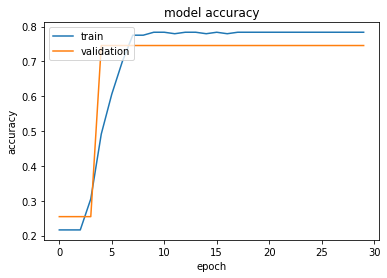

----------------------------------------------------------------------------------------------------


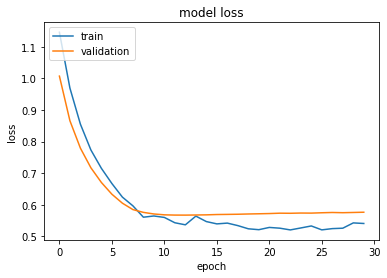

----------------------------------------------------------------------------------------------------


In [96]:
get_results(model,history)

### **3.2.Modelo GRU**

In [69]:
MAX_SEQ_LENGTH = 81 
NUM_FEATURES = 46 
NUM_CLASSES = 2 
BATCH_SIZE = 16 
EPOCHS = 20

In [84]:
model_GRUv1 = Sequential()

# Primera capa
model_GRUv1.add(keras.layers.GRU(16, input_shape = (n_chunks, chunk_size) , return_sequences = True))
model_GRUv1.add(keras.layers.Dropout(0.2))

# Segunda capa
model_GRUv1.add(keras.layers.GRU(8))
model_GRUv1.add(keras.layers.Dropout(0.4))

# Tercera capa
model_GRUv1.add(keras.layers.Dense(8))
model_GRUv1.add(keras.layers.Activation('relu'))

model_GRUv1.add(keras.layers.Dense(2))
model_GRUv1.add(keras.layers.Activation('softmax'))

model_GRUv1.compile(loss = 'categorical_crossentropy', optimizer = "adam" , metrics = ["accuracy", tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes = 2)])

In [85]:
model_GRUv1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 81, 16)            3072      
                                                                 
 dropout_16 (Dropout)        (None, 81, 16)            0         
                                                                 
 gru_17 (GRU)                (None, 8)                 624       
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 8)                 72        
                                                                 
 activation_19 (Activation)  (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 2)               

In [86]:
# Entrenando
epoch = 30
batchS = 16

history = model_GRUv1.fit(np.array(data_training[0:train]), np.array(target_training[0:train]), epochs = epoch,
                    validation_data = (np.array(data_training[train:]), np.array(target_training[train:])), 
                    batch_size=batchS, verbose = 1)

Epoch 1/30
15/15 [==============================] - 7s 153ms/step - loss: 0.6301 - accuracy: 0.7034 - precision_4: 0.7034 - recall_4: 0.7034 - f1_score: 0.5111 - val_loss: 0.5902 - val_accuracy: 0.7458 - val_precision_4: 0.7458 - val_recall_4: 0.7458 - val_f1_score: 0.4272
Epoch 2/30
15/15 [==============================] - 1s 75ms/step - loss: 0.5383 - accuracy: 0.7754 - precision_4: 0.7754 - recall_4: 0.7754 - f1_score: 0.4368 - val_loss: 0.5695 - val_accuracy: 0.7458 - val_precision_4: 0.7458 - val_recall_4: 0.7458 - val_f1_score: 0.4272
Epoch 3/30
15/15 [==============================] - 1s 75ms/step - loss: 0.5567 - accuracy: 0.7712 - precision_4: 0.7712 - recall_4: 0.7712 - f1_score: 0.4354 - val_loss: 0.5721 - val_accuracy: 0.7458 - val_precision_4: 0.7458 - val_recall_4: 0.7458 - val_f1_score: 0.4272
Epoch 4/30
15/15 [==============================] - 1s 85ms/step - loss: 0.5559 - accuracy: 0.7839 - precision_4: 0.7839 - recall_4: 0.7839 - f1_score: 0.4580 - val_loss: 0.5750 - 

In [87]:
def get_results(model, history):
  print('-'*100)
  print('-'*100)
  """result = model.evaluate(np.array(data_test), np.array(target_test))
  print('-'*20)
  for name, value in zip(model.metrics_names, result):
    print(name, value)"""
  
  print('-'*100)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.savefig('destination_path.eps', format='eps', dpi=1000)
  plt.show()

  print('-'*100)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  #plt.savefig('destination_path1.eps', format='eps', dpi=1000)
  plt.show()
  print('-'*100)

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


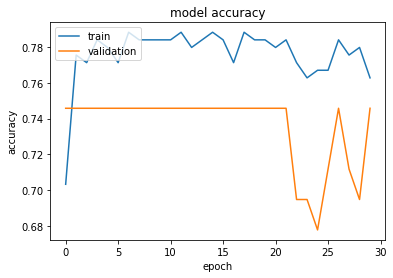

----------------------------------------------------------------------------------------------------


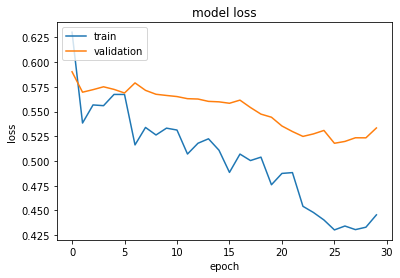

----------------------------------------------------------------------------------------------------


In [88]:
get_results(model_GRUv1,history)